In [1]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch

from src import datasets, metrics

In [2]:
import tomllib

datadir = Path('../data')
configfile = Path("config.toml")

with configfile.open('rb') as f:
    config = tomllib.load(f)
print(config)

{'ptb': 'heart', 'arrhythmia': 'heart_big'}


In [3]:
trainfile = datadir / (config['arrhythmia'] + '_train.parq')
testfile = datadir / (config['arrhythmia'] + '_test.parq')
trainfile, testfile

(PosixPath('../data/heart_big_train.parq'),
 PosixPath('../data/heart_big_test.parq'))

Get the 1D data into a 2D matrix

In [ ]:
shape = (16, 12)
traindataset = datasets.HeartDataset2D(trainfile, target="target", shape=shape)
testdataset = datasets.HeartDataset2D(testfile, target="target", shape=shape)
traindataset, testdataset
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS")
else:
    device = "cpu"


In [ ]:
import numpy as np
from collections import Counter

# Check originele distributie
y_train = traindataset.y.numpy()
print("Original distribution:", Counter(y_train))

# Strategie: maak het meer gebalanceerd
# Doel: ~5000 samples per klasse (genoeg voor training, niet te extreem)
target_samples = 5000

# Indices per klasse
indices_per_class = {}
for class_id in range(5):
    indices_per_class[class_id] = np.where(y_train == class_id)[0]

# Sampling strategie
sampled_indices = []

for class_id, indices in indices_per_class.items():
    n_samples = len(indices)
    
    if n_samples > target_samples:
        # Downsample
        sampled = np.random.choice(indices, target_samples, replace=False)
    else:
        # Upsample (met replacement voor kleine klassen)
        sampled = np.random.choice(indices, target_samples, replace=True)
    
    sampled_indices.extend(sampled)

# Shuffle
sampled_indices = np.array(sampled_indices)
np.random.shuffle(sampled_indices)

# Update dataset
traindataset = traindataset.x[sampled_indices]
traindataset = traindataset.y[sampled_indices]

print("New distribution:", Counter(traindataset.y.numpy()))

Original distribution: Counter({np.int64(0): 72471, np.int64(4): 6431, np.int64(2): 5788, np.int64(1): 2223, np.int64(3): 641})
New distribution: Counter({np.int64(0): 5000, np.int64(3): 5000, np.int64(4): 5000, np.int64(1): 5000, np.int64(2): 5000})


Let's see how that works. 
Compare this to the 1D data to see if you understand the transformation.

(torch.Size([1, 16, 12]), tensor(0))

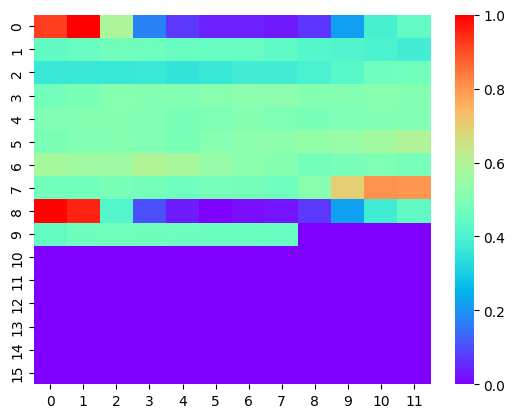

In [6]:
x, y = traindataset[0]
viz = x.squeeze().cpu().numpy()
sns.heatmap(viz, cmap='rainbow')
x.shape, y

Load into a streamer

In [7]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(781, 684)

In [8]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([32, 1, 16, 12]), torch.Size([32]))

`mltrainer` provides a ConvBlock, which makes it easier to stack block in the model.
It also provides an architecture inspired by AlexNet (2012) which is used as a starting point for image classification.

Feel free to experiment with other architectures here:
- adding ideas like resnet, googlenet, squeeze-excite, or even vision transformers (eg see [torch docs](https://docs.pytorch.org/tutorials/beginner/vt_tutorial.html#classifying-images-with-deit) ) 
- add additional layers like dropout, batchnorm, etc.
- experiment with different ways to go from 4D to 2D tensors

In [9]:
from mltrainer.imagemodels import CNNConfig, CNNblocks

In [ ]:
config = CNNConfig(
    matrixshape=shape,
    batchsize=32,
    input_channels=1,
    hidden=32,
    kernel_size=3,
    maxpool=2,
    num_layers=3,
    num_classes=5,
)
model = CNNblocks(config)
model(x).shape

Calculated matrix size: 48
Caluclated flatten size: 1536


torch.Size([32, 5])

In [11]:
yhat = model(x)

The data is unbalanced, so we are interested in much more than just accuracy.

In [12]:
config.__dict__

{'matrixshape': (16, 12),
 'batchsize': 32,
 'input_channels': 1,
 'hidden': 32,
 'kernel_size': 3,
 'maxpool': 2,
 'num_layers': 2,
 'num_classes': 5}

Read [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) about micro and macro F1 scores.


In [13]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

In [15]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mads_exam_v2.db")
mlflow.set_experiment("2D alexnet")

2025/06/18 12:15:12 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/06/18 12:15:12 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2025/06/18 12:15:12 INFO mlflow.tracking.fluent: Experiment with name '2D alexnet' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/azureuser/MADS-exam-25/notebooks_adriaan/mlruns/3', creation_time=1750248912301, experiment_id='3', last_update_time=1750248912301, lifecycle_stage='active', name='2D alexnet', tags={}>

In [18]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=10,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer) // 5,
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    # modify the tags when you change them!
    mlflow.set_tag("model", "Conv2D")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(config.__dict__)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("shape0", shape[0])
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=None,
        )
    trainer.loop()


2025-06-18 12:16:56.096 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to logs/heart2D/20250618-121656
100%|██████████| 156/156 [00:04<00:00, 33.22it/s]
2025-06-18 12:17:04.482 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 0.5662 test 0.7269 metric ['0.7408', '0.7408', '0.4949', '0.7408', '0.7826']
100%|██████████| 156/156 [00:04<00:00, 35.16it/s]
2025-06-18 12:17:11.901 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 0.4957 test 0.9100 metric ['0.6558', '0.6558', '0.4519', '0.6558', '0.8023']
100%|██████████| 156/156 [00:04<00:00, 36.89it/s]
2025-06-18 12:17:19.151 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 0.4343 test 0.5169 metric ['0.8309', '0.8309', '0.5606', '0.8309', '0.8028']
100%|██████████| 156/156 [00:04<00:00, 35.78it/s]
2025-06-18 12:17:26.608 | INFO     | mltrainer.trainer:report:209 - Epoch 3 train 0.4114 test 0.4966 metric ['0.8421', '0.8421', '0.6038', '0.8421', '0.8583']
100%|██████████| 156/156 [00:04<00:00, 36.55it

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

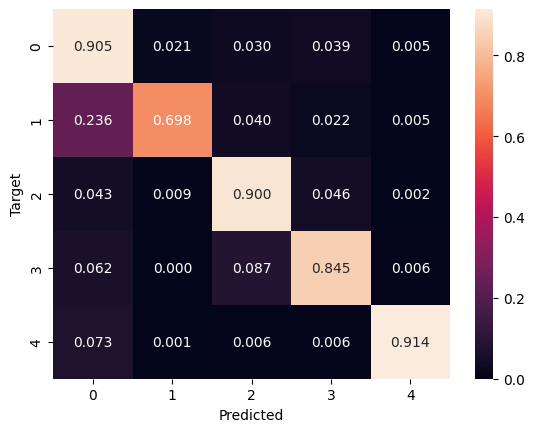

In [19]:
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")